In [2]:
#위스콘신 유방암 데이터 예측 분석 (앙상블)
# 필요 모듈 데이터 로드
import pandas as pd

from sklearn.ensemble import VotingClassifier #앙상블 보팅 분류기
from sklearn.linear_model import LogisticRegression #로지스틱 회귀
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.datasets import load_breast_cancer #위스콘신 유방암 데이터
from sklearn.model_selection import train_test_split #훈련, 테스트 데이터 분할
from sklearn.metrics import accuracy_score #정확도

# 유방암 데이터 로드
cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [13]:
# 로지스틱 회귀와 KNN을 기반으로 보팅 분류기 생성(소프트 보팅)
# 개별 모델은 로지스틱 회귀와 KNN
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR',lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


In [5]:
# 랜덤 포레스트 (사용자 행동 인식 데이터 세트 활용)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [17]:
# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음
# 이를 DataFrame으로 로드
feature_name_df = pd.read_csv('C:/Users/niceq/Documents/DataScience/Python ML Guide/human_activity/features.txt',
                               sep='\s+', header=None, names=['column_index', 'column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [18]:
# 중복된 피처명 파악하기
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [2]:
# 중복된 피처명에 _1 또는 _2 추가하는 함수
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                        if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df    

In [3]:
# get_human_dataset 함수 생성
import pandas as pd

def get_human_dataset():

    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep로 할당
    feature_name_df = pd.read_csv('../human_activity/features.txt',
                               sep='\s+', header=None, names=['column_index', 'column_name'])
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DF 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DF에 피처명을 칼럼으로 부여하기 위헤 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터세트와 테스트 피처 데이터를 DF로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('../human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('../human_activity/test/X_test.txt', sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터를 DF로 로딩하고 칼럼명은 action 부여
    y_train = pd.read_csv('../human_activity/train/y_train.txt', sep='\s+', header=None,names=['action'])
    y_test = pd.read_csv('../human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])

    # 로드된 학습/테스트용 DF 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

C:\Users\niceq\AppData\Local\Temp\ipykernel_18720\3854546761.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[1] > 0 else x[0], axis=1)
C:\Users\niceq\AppData\Local\Temp\ipykernel_18720\3854546761.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])


In [21]:
# 결정 트리에서 사용한 get_human_dataset() 이용해 학습/테스트용 DF 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9196


In [24]:
# GridSearchCV를 이용해 랜덤 포레스트의 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12], 
    'min_samples_split' : [2, 8, 16]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
# 멀티 코어 환경에서는 n_jobs=-1 파라미터 추가 시 모든 CPU 코어를 이용해 학습 가능
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도: 0.9165


In [25]:
# 추출된 최적 하이퍼 파라미터로 별도의 테스트 데이터 세트에서 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16,
                                min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9260


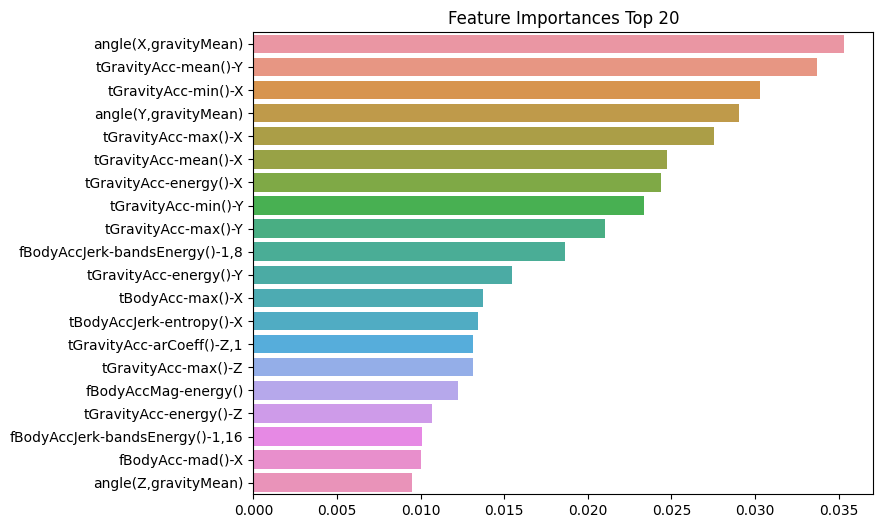

In [26]:
#피처의 중요도를 파악해 막대그래프로 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

# 중요도 값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature Importances Top 20')
sns.barplot(x=ftr_top20, y= ftr_top20.index)
plt.show()

In [7]:
# # GBM (사용자 행동 인식 데이터 세트 활용)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [8]:
# GBM
import time

X_train, X_test, y_train, y_test = get_human_dataset()

#GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행시간: {0:.4f} 초". format(time.time() - start_time))

GBM 정확도: 0.9393
GBM 수행시간: 841.0005 초


In [8]:
# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
# XGBoost 버전 확인
print(xgb.__version__)

1.7.3


In [3]:
# 위스콘신 유방암 예측 (xgboost)
from xgboost import plot_importance #시각화 모듈
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer # 유방암 데이터셋 로드
from sklearn.model_selection import train_test_split #훈련, 테스트 데이터 분할
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
# 레이블 값의 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [5]:
# 데이터 세트 분할
# cancer_df 에서 feature 용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 컬럼: Label
# Feature용 DataFrame은 cancer_df의 첫번째-맨 마지막 칼럼에서 두 번재 칼럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80% 학습용, 20% 테스트용
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2,
                                                    random_state=156)

# 위에서 만든 학습용 데이터를 다시 쪼개서 90% 학습 10%는 검증용으로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1,
                                            random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [9]:
# DataFrame 기반의 학습 데이터 세트와 테스트 데이터 세트 > DMatrix
# 만약 구버전 XGBoost에서 DF으로 DMatrix 생성이 안 될 경우 X_train.values로 넘파이 변환
# 학습, 검증, 테스트용 DMatrix 생성
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [13]:
# XGBoost 하이퍼 파라미터 설정
params = { 'max_depth':3, #트리 최대 깊이
          'eta':0.05, #학습률
          'objective':'binary:logistic', #예제 데이터가 0 또는 1인 이진분류이므로
          'eval_metric':'logloss' #오류 함수의 평가 성능 지표
         }
num_rounds = 400 #부스팅 반복 횟수

In [14]:
# 지정된 하이퍼 파라미터로 XGBoost 모델 학습
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기
eval_list = [(dtr, 'train'), (dval, 'eval')]
# 또는 eval_list = [(dval, 'eval')]만 명기해도 무방

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round=num_rounds,
                      early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

In [16]:
# xgboost를 이용해 테스트 데이터 세트 예측 수행
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 list 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
        F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [21]:
# get_clf_eval() 함수를 적용해 XGBoost 예측 성능 평가
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,        F1: 0.9677, AUC: 0.9465


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

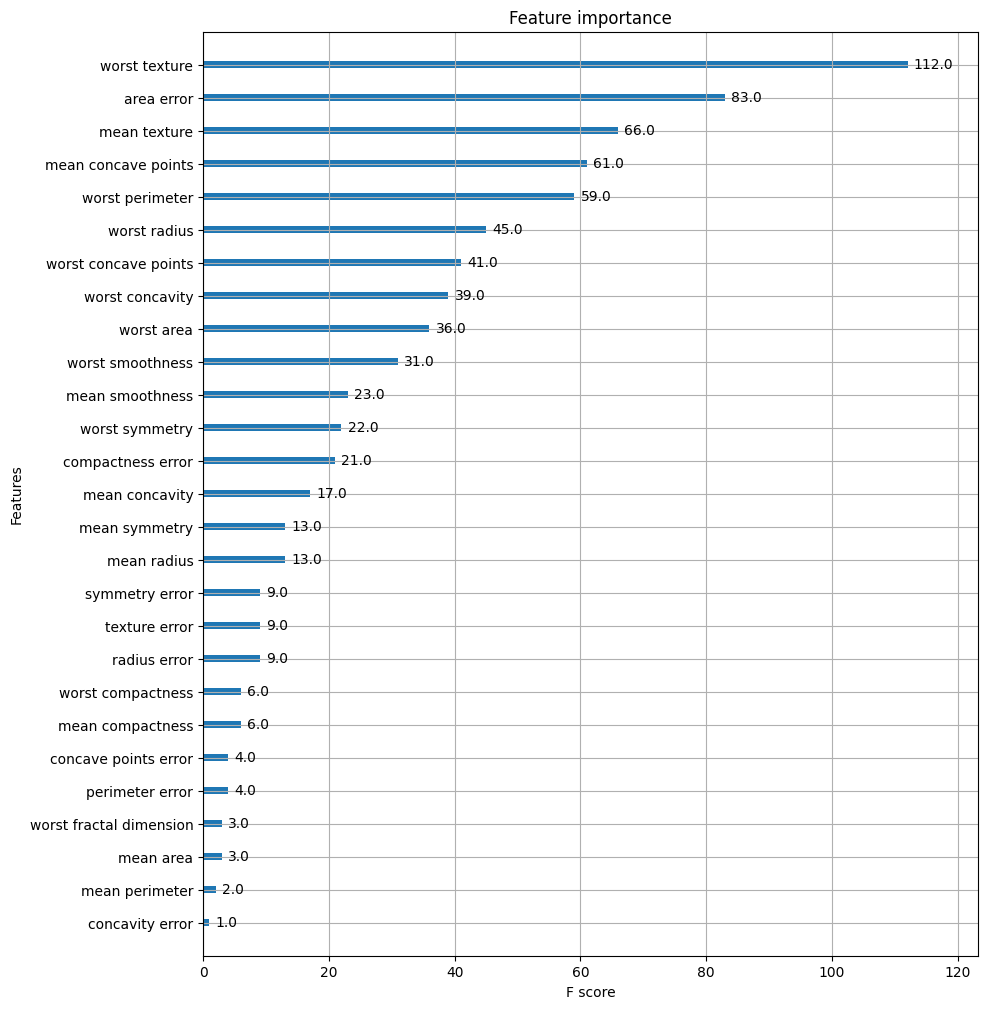

In [22]:
# xgboost 패키지에 내장된 시각화 기능 수행
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

In [24]:
# xgboost의 최적 파라미터 추출 cv() API
xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(),
           obj=None, feval=None, maximaize=False, early_stopping_rounds=None, fpreproc=None,
           as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)

NameError: name 'dtrain' is not defined

In [6]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
import xgboost as xgb
from xgboost import XGBClassifier

# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3,
                            eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
        F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [8]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,        F1: 0.9744, AUC: 0.9530


In [9]:
# 사이킷런 래퍼 XGBoost 조기 중단
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric='logloss',
                eval_set=evals, verbose=True)


ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [10]:
# 조기 중단 학습된 XGBClassifier 예측 성능
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,        F1: 0.9677, AUC: 0.9465


In [11]:
# early_stopping_rounds를 10으로 줄인 예측 성능
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 10, eval_metric='logloss',
                eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [12]:
# 조기 중단 10번으로 학습된 XGBClassifier 예측 성능
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

오차 행렬
[[34  3]
 [ 3 74]]
정확도: 0.9474, 정밀도: 0.9610, 재현율: 0.9610,        F1: 0.9610, AUC: 0.9400


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

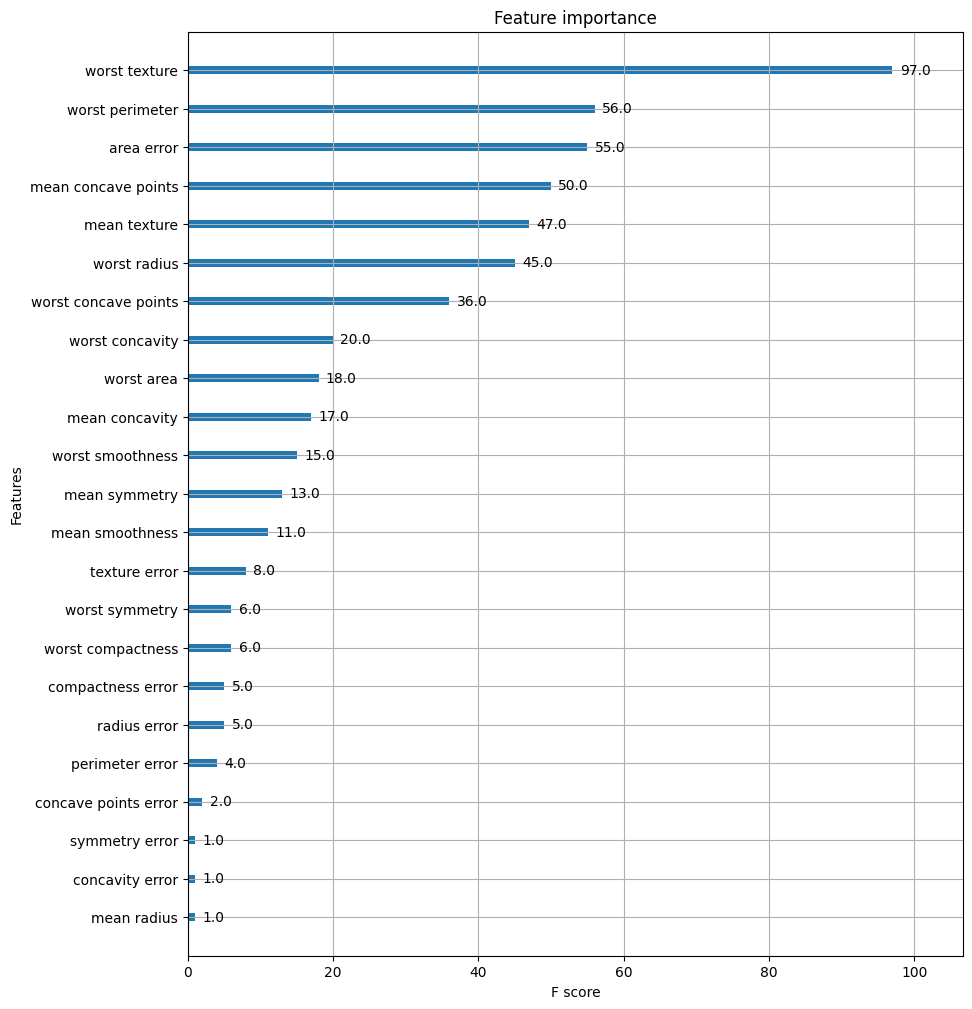

In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

In [21]:
# 위스콘신 유방암 예측 (LightGBM 활용)
import lightgbm as lgb
# lightGBM 파이썬 패키지 lightgbm 에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# lightgbm 업데이트로 인한 조기 중단 import
from lightgbm import early_stopping, log_evaluation

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']=dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80% 학습 데이터, 20% 테스트 데이터
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개 90% 학습, 10% 검증용 데이터 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

# n_estimators 는 400
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# lightGBM도 XGBoost와 동일하게 조기 중단 수행 가능 (4.0.0 버전)
lgbm_wrapper = lgb.LGBMClassifier()
lgbm_wrapper.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)],
    eval_metric='logloss',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=1)]
)

preds = lgbm_wrapper.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 251, number of negative: 158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613692 -> initscore=0.462858
[LightGBM] [Info] Start training from score 0.462858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's binary_logloss: 0.586411	valid_1's binary_logloss: 0.599048
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's binary_logloss: 0.52049	valid_1's binary_logloss: 0.5

In [20]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 3 74]]
정확도: 0.9474, 정밀도: 0.9610, 재현율: 0.9610,        F1: 0.9610, AUC: 0.9400


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

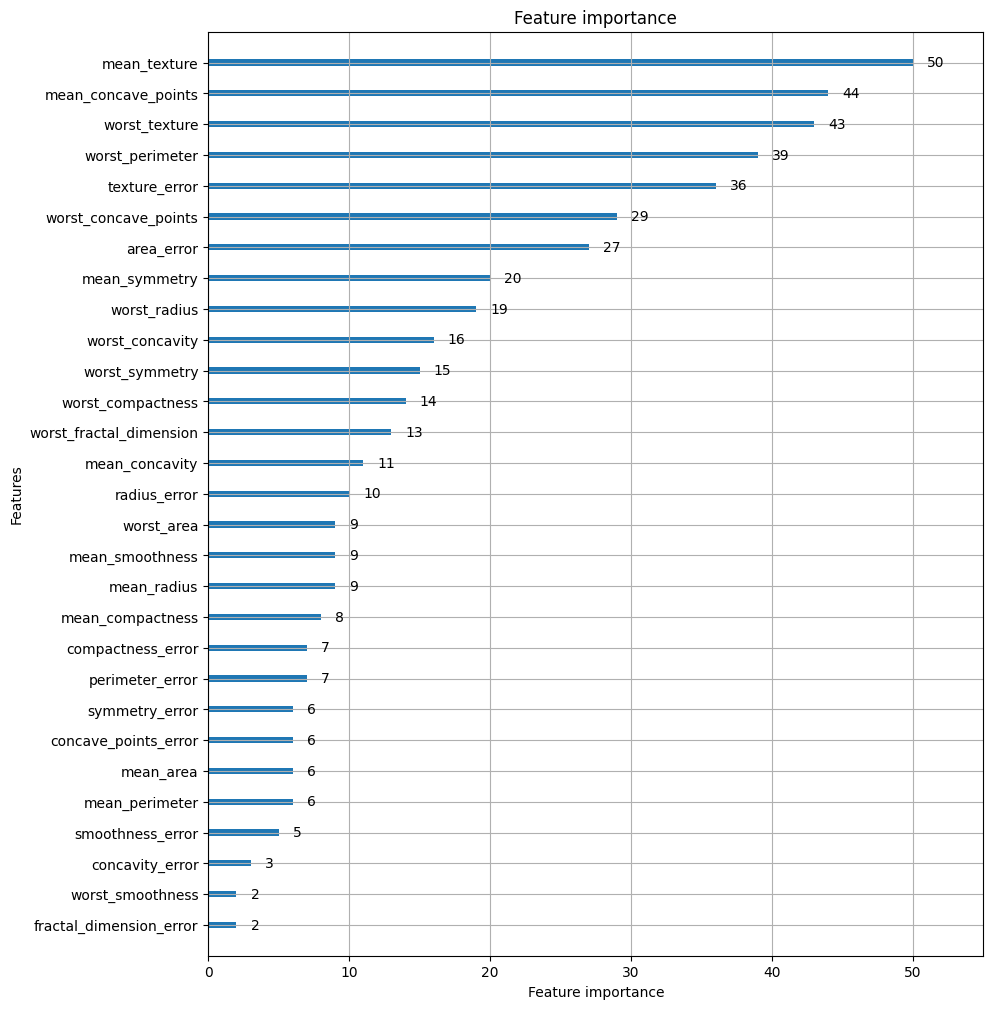

In [22]:
# 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(lgbm_wrapper, ax=ax)

In [1]:
from hyperopt import hp

# -10에서 10까지 1간격을 가지는 입력 변수 x와 -15~15까지 1간격으로 입력 변수 y 설정
search_space = {'x':hp.quniform('x', -10, 10, 1), 'y':hp.quniform('y', -15, 15, 1)}

In [3]:
from hyperopt import STATUS_OK

# 목적 함수 생성. 변숫값과 검색 공간을 가지는 딕셔너릴 인자로 받고, 특정 값 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y

    return retval

In [4]:
import numpy as np
from hyperopt import fmin, tpe, Trials
# 입력 결괏값을 저장한 Trials 객체값 생성
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변수값을 5번의 입력값 시도(max_evals=5)로 찾아냄
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5,
               trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 352.98trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [5]:
trial_val = Trials()

# max_evals=20으로 하여 테스트 재수행
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20,
               trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1010.89trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [7]:
# fmin() 인자로 들어가는 Trails 객체의 results 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값}와 같은 딕셔너리
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [8]:
# Trials 객체의 vals 속성에 {'입력변수명': 개별 수형 시마다 입력된 값의 리스트} 형태로 저장
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [10]:
import pandas as pd

# results에서 loss 키 값에 해당하는 밸류들을 추출하여 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame 생성
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


In [11]:
# 위스콘신 유방암 예측 (HyperOpt 활용)

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']=dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80% 학습 데이터, 20% 테스트 데이터
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개 90% 학습, 10% 검증용 데이터 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [12]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색
xgb_search_space= {'max_depth': hp.quniform('max_depth', 5, 20, 1),
                   'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                   'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                   'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 1)
                  }

In [13]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

#fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형인
#XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
#정확도는 높을수록 더 좋은 수치임 -1* 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    #수행 시간 절약을 위해 n_estimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1 곱합
    return {'loss':-1 * np.mean(accuracy), 'status':STATUS_OK}

In [14]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()

best = fmin(fn=objective_func,
               space=xgb_search_space,
               algo=tpe.suggest,
               max_evals=50, #최대 반복 횟수 지정
               trials=trial_val,
               rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:12<00:00,  4.09trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


In [15]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(round(best['colsample_bytree'], 5),
                                                                                            round(best['learning_rate'], 5),
                                                                                            int(best['max_depth']),
                                                                                            int(best['min_child_weight'])))

colsample_bytree:0.54241, learning_rate:0.12601, max_depth:17, min_child_weight:2


In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
        F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [17]:
xgb_wrapper = XGBClassifier(n_estiamtors=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds =50, eval_metric='logloss',
                eval_set=evals, verbose=True)


preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[17:50:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estiamtors" } are not used.

[0]	validation_0-logloss:0.58942	validation_1-logloss:0.62048
[1]	validation_0-logloss:0.50801	validation_1-logloss:0.55913
[2]	validation_0-logloss:0.44160	validation_1-logloss:0.50928
[3]	validation_0-logloss:0.38734	validation_1-logloss:0.46815
[4]	validation_0-logloss:0.34224	validation_1-logloss:0.43913
[5]	validation_0-logloss:0.30425	validation_1-logloss:0.41570
[6]	validation_0-logloss:0.27178	validation_1-logloss:0.38953
[7]	validation_0-logloss:0.24503	validation_1-logloss:0.37317
[8]	validation_0-logloss:0.22050	validation_1-logloss:0.35628
[9]	validation_0-logloss:0.19873	validation_1-logloss:0.33798
[10]	validation_0-logloss:0.17945	validation_1-logloss:0.32463
[11]	validation_0-logloss:0.16354	validation_1-logloss:0.31384
[12]	validation_0-logloss:0.15032	validation_1-logloss:0.30607
[13]	validation_0-logloss:0.13813	validation_

C:\Users\niceq\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\niceq\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.02904	validation_1-logloss:0.24858
[47]	validation_0-logloss:0.02849	validation_1-logloss:0.25082
[48]	validation_0-logloss:0.02802	validation_1-logloss:0.24968
[49]	validation_0-logloss:0.02741	validation_1-logloss:0.24913
[50]	validation_0-logloss:0.02689	validation_1-logloss:0.24924
[51]	validation_0-logloss:0.02644	validation_1-logloss:0.24483
[52]	validation_0-logloss:0.02593	validation_1-logloss:0.24508
[53]	validation_0-logloss:0.02534	validation_1-logloss:0.24153
[54]	validation_0-logloss:0.02500	validation_1-logloss:0.23781
[55]	validation_0-logloss:0.02458	validation_1-logloss:0.23909
[56]	validation_0-logloss:0.02422	validation_1-logloss:0.23809
[57]	validation_0-logloss:0.02380	validation_1-logloss:0.23843
[58]	validation_0-logloss:0.02348	validation_1-logloss:0.23802
[59]	validation_0-logloss:0.02310	validation_1-logloss:0.23837
[60]	validation_0-logloss:0.02275	validation_1-logloss:0.23923
[61]	validation_0-logloss:0.02257	validation_1-logloss: